* 在GAN这种完全无监督的方式加上一个标签或一点监督信息,使整个网络就可看成半监督模型

In [15]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch import autograd
from torchvision.utils import save_image
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
batch_size = 100
sample_dir = 'cgan_samples'

if not os.path.exists(smaple_dir):
    os.makedirs(smaple_dir)

trans = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]
)

mnist = torchvision.datasets.MNIST(root='data3',train=True,transform=trans,download=False)
data_loader = torch.utils.data.DataLoader(dataset=mnist,batch_size=batch_size,shuffle=True)

In [5]:
# CGAN判别器

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()


In [6]:
# CGAN生成器

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [7]:
# 定义判别器、生成器以及损失函数

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

total_step = len(data_loader)

In [16]:
# 开始训练

writer = SummaryWriter(log_dir='logs')

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader):
        step = epoch * len(data_loader) + i + 1
        images = images.to(device)
        labels = labels.to(device)

        # 定义图像是真或假的标签
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.randint(0, 10, (batch_size,)).to(device)

        # 训练判别器
        real_validity = D(images, labels)
        d_loss_real = criterion(real_validity, real_labels)
        real_score = real_validity

        z = torch.randn(batch_size, 100).to(device)
        fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
        fake_images = G(z, fake_labels)
        fake_validity = D(fake_images, fake_labels)
        d_loss_fake = criterion(fake_validity, torch.zeros(batch_size).to(device))
        fake_score = fake_images
        d_loss = d_loss_fake + d_loss_real

        # 梯度清零
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # 训练生成器
        z = torch.randn(batch_size, 100).to(device)
        fake_images = G(z, fake_labels)
        validity = D(fake_images, fake_labels)
        g_loss = criterion(validity, torch.ones(batch_size).to(device))

        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        writer.add_scalars('scalars', {'g_loss':g_loss,'d_loss':d_loss}, step)

        if (i+1)%200 == 0:
            print(f"epoch [{epoch}/{num_epochs}], step [{i+1}/{total_step}],d_loss:{d_loss.item():.4f}, g_loss:{g_loss.item():.4f}, D(x):{real_score.mean().item():.2f}, D(G(z)):{fake_score.mean().item():.2f}")

    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

torch.save(G.state_dict(), 'CG.ckpt')
torch.save(D.state_dict(), 'CD.ckpt')

epoch [0/50], step [200/600],d_loss:1.5484, g_loss:0.7263, D(x):0.48, D(G(z)):-0.68
epoch [0/50], step [400/600],d_loss:0.3395, g_loss:2.8581, D(x):0.85, D(G(z)):-0.58
epoch [0/50], step [600/600],d_loss:0.4821, g_loss:2.8364, D(x):0.85, D(G(z)):-0.58
epoch [1/50], step [200/600],d_loss:0.6441, g_loss:3.4752, D(x):0.77, D(G(z)):-0.63
epoch [1/50], step [400/600],d_loss:0.1678, g_loss:5.3182, D(x):0.95, D(G(z)):-0.60
epoch [1/50], step [600/600],d_loss:0.2025, g_loss:4.4547, D(x):0.95, D(G(z)):-0.55
epoch [2/50], step [200/600],d_loss:0.1673, g_loss:4.5609, D(x):0.97, D(G(z)):-0.70
epoch [2/50], step [400/600],d_loss:0.1442, g_loss:4.4662, D(x):0.94, D(G(z)):-0.74
epoch [2/50], step [600/600],d_loss:0.2234, g_loss:3.8716, D(x):0.93, D(G(z)):-0.70
epoch [3/50], step [200/600],d_loss:0.2132, g_loss:5.6217, D(x):0.94, D(G(z)):-0.67
epoch [3/50], step [400/600],d_loss:0.2853, g_loss:4.7992, D(x):0.91, D(G(z)):-0.71
epoch [3/50], step [600/600],d_loss:0.2444, g_loss:5.8260, D(x):0.91, D(G(z)

(-0.5, 301.5, 301.5, -0.5)

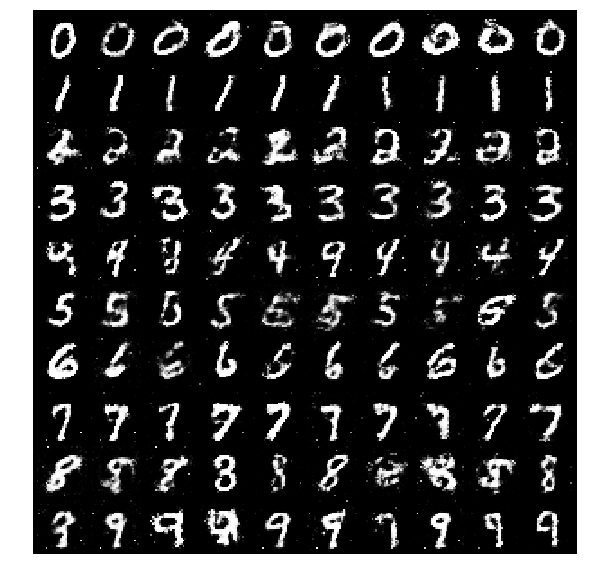

In [17]:
# 指定条件下生成图像

from torchvision.utils import make_grid
z = torch.randn(100,100).to(device)
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).to(device)

images = G(z, labels).unsqueeze(1)
grid = make_grid(images, nrow=10, normalize=True)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1,2,0).detach().cpu().numpy(), cmap='binary')
ax.axis('off')

In [22]:
# 查看指定标签的数据

def generate_digit(generator, digit):
    z = torch.randn(1,100).to(device)
    label = torch.LongTensor([digit]).to(device)
    img = generator(z, label).detach().cpu()
    img = 0.5 * img + 0.5
    return transforms.ToPILImage()(img)

generate_digit(G, 9)